## Resource to follow to get understand the details 

https://blog.roboflow.com/image-contouring/

https://blog.roboflow.com/image-contouring-computer-vision/

####FINAL ANSWERS #####

In [2]:
import cv2
import time
import imageio
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def is_contour_nearly_closed(contour, tolerance=30):
    """Checks if a contour is nearly closed within a given tolerance.

    Args:
        contour: The contour to check (a NumPy array of points).
        tolerance: The maximum allowed difference between the first and last points' coordinates.

    Returns:
        True if the contour is nearly closed, False otherwise.
    """

    if len(contour) < 2:
        return False

    first_point = contour[0][0]  # Get the first point (x, y)
    last_point = contour[-1][0] # Get the last point (x, y)

    return abs(first_point[0] - last_point[0]) <= tolerance and \
           abs(first_point[1] - last_point[1]) <= tolerance

In [ ]:
is_contour_nearly_closed(contour, tolerance=20)

In [ ]:
__init__



In [6]:
def calculate_iou_rectangles(contour1, contour2):
    """Calculates the Intersection over Union (IoU) of two contour bounding rectangles.

    Args:
        contour1: The first contour (NumPy array).
        contour2: The second contour (NumPy array).

    Returns:
        The IoU value (float) or 0 if no intersection.
    """

    # Get bounding rectangles
    x1, y1, w1, h1 = cv2.boundingRect(contour1)
    x2, y2, w2, h2 = cv2.boundingRect(contour2)

    # Calculate coordinates of intersection rectangle
    x_intersect = max(x1, x2)
    y_intersect = max(y1, y2)
    w_intersect = max(0, min(x1 + w1, x2 + w2) - x_intersect)
    h_intersect = max(0, min(y1 + h1, y2 + h2) - y_intersect)

    # Calculate area of intersection rectangle
    intersection_area = w_intersect * h_intersect

    # Calculate area of union rectangle
    area1 = w1 * h1
    area2 = w2 * h2
    union_area = area1 + area2 - intersection_area

    if union_area == 0:
        return 0  # No overlap

    iou = intersection_area / union_area
    return iou

In [22]:


def detect_water_drops_edge_mask(image_path):
    """
    Detects water drop-shaped edges as defects in an image and saves the result as an image with highlighted edges.
    
    Args:
        image_path (str): Path to the input image file.
    """
    
    # Read the input image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read image {image_path}")
        return

    # Convert to grayscale for edge detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Create a black image for drawing contours
    black_image = np.zeros_like(image)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (1, 1), 0)
    
    # Detect edges using Canny edge detector
    edges = cv2.Canny(blurred, 170, 250)
    
    # Find contours from the edge map
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    # List to store detected water drop contours
    water_drops = []

    # Process each contour
    for contour in contours:
        # Only consider nearly closed contours
        if is_contour_nearly_closed(contour):

            # Filter by area and contour length
            area = cv2.contourArea(contour)
            if 100 < area < 10000 and len(contour) > 10:

                # Calculate circularity metric
                perimeter = cv2.arcLength(contour, True)
                circularity = (4 * np.pi * area) / (perimeter * perimeter) if perimeter > 0 else 0
                
                # Calculate convexity metric
                hull = cv2.convexHull(contour)
                convex_area = cv2.contourArea(hull)
                convexity = area / convex_area if convex_area > 0 else 0
                
                # Apply shape-based filters
                if convexity > 0.7 and circularity < 0.4:
                    # Check for overlap with existing detections
                    is_overlap = any(calculate_iou_rectangles(contour, existing) > 0.4 for existing in water_drops)
                    
                    if not is_overlap:
                        # Add to detected water drops and draw on output image
                        water_drops.append(contour)
                        cv2.drawContours(black_image, [contour], -1, (0, 255, 0), 2)
                        
    # Print detection summary
    print(f"Total water drop-shaped defected holes detected: {len(water_drops)}")
    
    # Define output image name
    output_image = "defect_detection_contour.jpg"
    
    # Save the output image
    cv2.imwrite(output_image, black_image)
    print(f"Saved water drop edges image as {output_image}")

# Example usage
detect_water_drops_edge_mask('D:/Defect_detectiontask_opencv/Image1.jpg')

Total water drop-shaped defected holes detected: 16
Saved water drop edges image as defect_detection_contour.jpg


### Tested to detect different shapes of contours

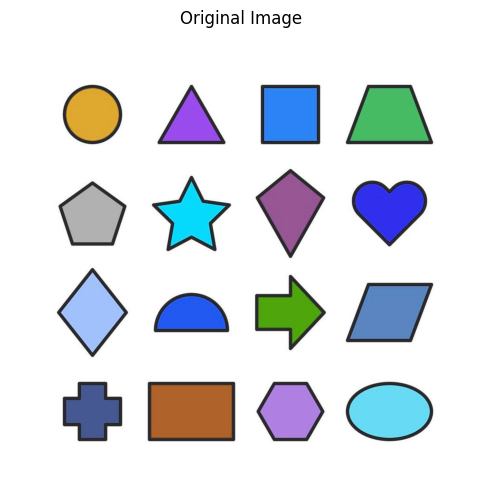

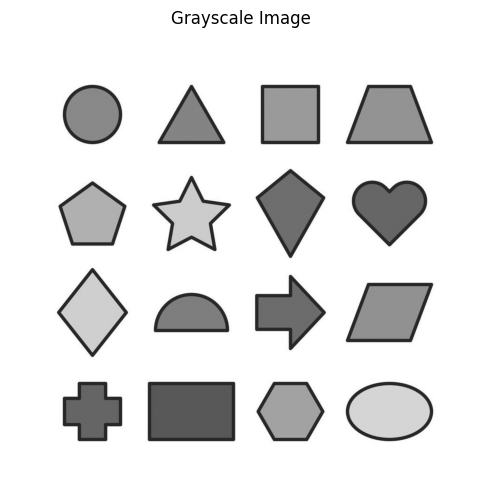

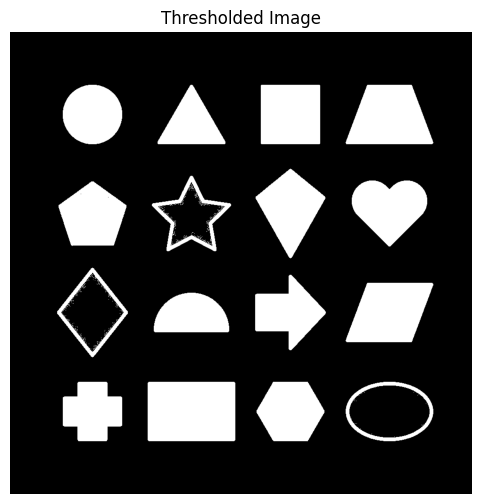

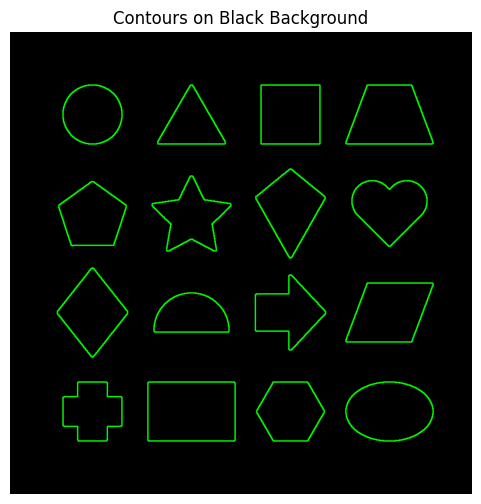

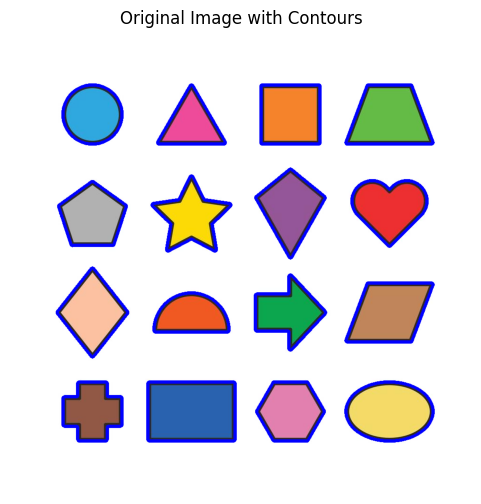

In [3]:
# Read the image
image = cv2.imread('D:/Defect_detectiontask_opencv/shapes.jpg')

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply thresholding to create a binary image
_, binary = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)

# Find contours in the binary image
contours, hierarchy = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create copies of the original image to draw contours
contour_image = image.copy()
contour_on_original = image.copy()

# Draw the contours on the binary (black) image
contour_black = np.zeros_like(image)
cv2.drawContours(contour_black, contours, -1, (0, 255, 0), 2)

# Draw the contours on the original image
cv2.drawContours(contour_on_original, contours, -1, (255,0, 0), 5)

# Convert images from BGR to RGB for visualization with matplotlib
contour_black_rgb = cv2.cvtColor(contour_black, cv2.COLOR_BGR2RGB)
contour_on_original_rgb = cv2.cvtColor(contour_on_original, cv2.COLOR_BGR2RGB)
original_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)



# Display the original image
plt.figure(figsize=(6, 6))
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

# Display the grayscale image
plt.figure(figsize=(6, 6))
plt.imshow(gray, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')
plt.show()

# Display the thresholded image
plt.figure(figsize=(6, 6))
plt.imshow(binary, cmap='gray')
plt.title('Thresholded Image')
plt.axis('off')
plt.show()

# Display the contour on a black background
plt.figure(figsize=(6, 6))
plt.imshow(contour_black_rgb)
plt.title('Contours on Black Background')
plt.axis('off')
plt.show()

# Display the original image with contours
plt.figure(figsize=(6, 6))
plt.imshow(contour_on_original_rgb)
plt.title('Original Image with Contours')
plt.axis('off')
plt.show()

## To check the details of the perimeter of contour

In [16]:


def detect_water_drops_edge_mask(image_path):
    """
    Detects water drop-shaped edges as defects in an image and saves the result as an image with highlighted edges.
    
    Args:
        image_path (str): Path to the input image file.
    """
    
    # Read the input image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read image {image_path}")
        return

    # Convert to grayscale for edge detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Create a black image for drawing contours
    black_image = np.zeros_like(image)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (1, 1), 0)
    
    # Detect edges using Canny edge detector
    edges = cv2.Canny(blurred, 170, 250)
    
    # Find contours from the edge map
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    # List to store detected water drop contours
    water_drops = []

    # Process each contour
    for contour in contours:
        # Only consider nearly closed contours
        if is_contour_nearly_closed(contour):

            # Filter by area and contour length
            area = cv2.contourArea(contour)
            if 100 < area < 10000 and len(contour) > 10:

                # Calculate circularity metric
                perimeter = cv2.arcLength(contour, True)
                circularity = (4 * np.pi * area) / (perimeter * perimeter) if perimeter > 0 else 0
                print(f"Area: {area}")            # Expected: 1600
                print("*"*20)
                print(f"Perimeter: {perimeter}")  # Expected: 160
                print(f"Circularity: {circularity}")  # Expected: < 1
                
                
                # Calculate convexity metric
                hull = cv2.convexHull(contour)
                convex_area = cv2.contourArea(hull)
                convexity = area / convex_area if convex_area > 0 else 0
                
                # Apply shape-based filters
                if convexity > 0.7 and circularity < 0.5:
                    # Check for overlap with existing detections
                    is_overlap = any(calculate_iou_rectangles(contour, existing) > 0.4 for existing in water_drops)
                    
                    if not is_overlap:
                        # Add to detected water drops and draw on output image
                        water_drops.append(contour)
                        cv2.drawContours(black_image, [contour], -1, (0, 255, 0), 2)
                        
    # Print detection summary
    print(f"Total water drop-shaped defected holes detected: {len(water_drops)}")
    
    # Define output image name
    output_image = "defect_detection_contour.jpg"
    
    # Save the output image
    cv2.imwrite(output_image, black_image)
    print(f"Saved water drop edges image as {output_image}")

# Example usage
detect_water_drops_edge_mask('D:/Defect_detectiontask_opencv/Image1.jpg')

Area: 233.0
********************
Perimeter: 1920.385987520218
Circularity: 0.0007939419109290051
Area: 1292.5
********************
Perimeter: 459.6883796453476
Circularity: 0.07686229803033588
Area: 1223.0
********************
Perimeter: 227.62236428260803
Circularity: 0.2966241188289036
Area: 1278.5
********************
Perimeter: 348.1147857904434
Circularity: 0.13257622744243672
Area: 1156.5
********************
Perimeter: 219.94826519489288
Circularity: 0.3004100235378248
Area: 2592.0
********************
Perimeter: 988.9747383594513
Circularity: 0.03330231806246631
Area: 1246.5
********************
Perimeter: 222.32590091228485
Circularity: 0.3168998438320127
Area: 1166.0
********************
Perimeter: 225.48022890090942
Circularity: 0.28819834358314944
Area: 2535.0
********************
Perimeter: 1004.915863275528
Circularity: 0.0315448468949573
Area: 1144.5
********************
Perimeter: 224.89444243907928
Circularity: 0.2843598093281415
Area: 1235.5
********************
Perim

###TO check the Big contour

In [18]:
import cv2
import numpy as np

def detect_water_drops_edge_mask(image_path):
    """
    Detects water drop-shaped edges as defects in an image and saves the result as an image with highlighted edges.
    
    Args:
        image_path (str): Path to the input image file.
    """
    
    # Read the input image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read image {image_path}")
        return

    # Convert to grayscale for edge detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Create a copy of the original image for drawing
    output_image = image.copy()
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    
    # Detect edges using Canny edge detector
    edges = cv2.Canny(blurred, 170, 250)
    
    # Find contours from the edge map
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    # List to store detected water drop contours
    water_drops = []
    largest_contour = None
    max_area = 0

    # Process each contour
    for contour in contours:
        area = cv2.contourArea(contour)
        
        # Identify the largest contour (potential big circle)
        if area > max_area:
            max_area = area
            largest_contour = contour

        # Only consider nearly closed contours
        if is_contour_nearly_closed(contour):

            # Filter by area and contour length
            if 100 < area < 10000 and len(contour) > 10:

                # Calculate circularity metric
                perimeter = cv2.arcLength(contour, True)
                circularity = (4 * np.pi * area) / (perimeter * perimeter) if perimeter > 0 else 0
                
                # Calculate convexity metric
                hull = cv2.convexHull(contour)
                convex_area = cv2.contourArea(hull)
                convexity = area / convex_area if convex_area > 0 else 0
                
                # Apply shape-based filters for water drop defects
                if convexity > 0.7 and circularity < 0.4:
                    # Check for overlap with existing detections
                    is_overlap = any(calculate_iou_rectangles(contour, existing) > 0.4 for existing in water_drops)
                    
                    if not is_overlap:
                        # Add to detected water drops and draw on output image in GREEN
                        water_drops.append(contour)
                        cv2.drawContours(output_image, [contour], -1, (0, 255, 0), 2)

    # Draw the largest contour (big circle) in BLUE if found
    if largest_contour is not None:
        cv2.drawContours(output_image, [largest_contour], -1, (255, 0, 0), 2)

    # Print detection summary
    print(f"Total water drop-shaped defected holes detected: {len(water_drops)}")
    
    # Define output image name
    output_image_path = "defect_detection_with_big_circle.jpg"
    
    # Save the output image
    cv2.imwrite(output_image_path, output_image)
    print(f"Saved water drop edges image as {output_image_path}")

# Example usage
detect_water_drops_edge_mask('D:/Defect_detectiontask_opencv/Image1.jpg')


Total water drop-shaped defected holes detected: 15
Saved water drop edges image as defect_detection_with_big_circle.jpg


####To check the details of largest contour

In [19]:
import cv2
import numpy as np

def detect_water_drops_edge_mask(image_path):
    """
    Detects water drop-shaped edges as defects in an image and prints the largest contour's properties.
    
    Args:
        image_path (str): Path to the input image file.
    """
    
    # Read the input image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read image {image_path}")
        return

    # Convert to grayscale for edge detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Create a copy of the original image for drawing
    output_image = image.copy()
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    
    # Detect edges using Canny edge detector
    edges = cv2.Canny(blurred, 170, 250)
    
    # Find contours from the edge map
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    largest_contour = None
    max_area = 0

    # Process each contour
    for contour in contours:
        area = cv2.contourArea(contour)
        
        # Identify the largest contour (potential big circle)
        if area > max_area:
            max_area = area
            largest_contour = contour

    # If a largest contour is found, calculate its properties
    if largest_contour is not None:
        # Compute area
        largest_area = cv2.contourArea(largest_contour)
        
        # Compute perimeter
        perimeter = cv2.arcLength(largest_contour, True)
        
        # Compute circularity
        circularity = (4 * np.pi * largest_area) / (perimeter * perimeter) if perimeter > 0 else 0
        
        # Compute convex hull and convex area
        hull = cv2.convexHull(largest_contour)
        convex_area = cv2.contourArea(hull)
        convexity = largest_area / convex_area if convex_area > 0 else 0

        # Draw the largest contour in BLUE
        cv2.drawContours(output_image, [largest_contour], -1, (255, 0, 0), 2)

        # Print the values
        print(f"Largest Contour Properties:")
        print(f"  - Area: {largest_area}")
        print(f"  - Perimeter: {perimeter}")
        print(f"  - Circularity: {circularity:.4f}")
        print(f"  - Convex Hull Area: {convex_area}")
        print(f"  - Convexity: {convexity:.4f}")
    
    # Save the output image
    output_image_path = "largest_contour_details.jpg"
    cv2.imwrite(output_image_path, output_image)
    print(f"Saved image with largest contour as {output_image_path}")

# Example usage
detect_water_drops_edge_mask('D:/Defect_detectiontask_opencv/Image1.jpg')


Largest Contour Properties:
  - Area: 261569.0
  - Perimeter: 1913.1799247264862
  - Circularity: 0.8980
  - Convex Hull Area: 262179.5
  - Convexity: 0.9977
Saved image with largest contour as largest_contour_details.jpg


##TO Check the contour points presents in the water_drops list

In [24]:
import cv2
import numpy as np

def detect_water_drops_edge_mask(image_path):
    """
    Detects water drop-shaped edges as defects in an image and prints details about detected contours.
    
    Args:
        image_path (str): Path to the input image file.
    """
    
    # Read the input image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read image {image_path}")
        return

    # Convert to grayscale for edge detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Create a black image for drawing contours
    black_image = np.zeros_like(image)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    
    # Detect edges using Canny edge detector
    edges = cv2.Canny(blurred, 170, 250)
    
    # Find contours from the edge map
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    # List to store detected water drop contours
    water_drops = []

    # Process each contour
    for contour in contours:
        # Only consider nearly closed contours
        if is_contour_nearly_closed(contour):
            # Calculate area
            area = cv2.contourArea(contour)

            # Filter by area and contour length
            if 100 < area < 10000 and len(contour) > 10:

                # Calculate circularity metric
                perimeter = cv2.arcLength(contour, True)
                circularity = (4 * np.pi * area) / (perimeter * perimeter) if perimeter > 0 else 0
                
                # Calculate convexity metric
                hull = cv2.convexHull(contour)
                convex_area = cv2.contourArea(hull)
                convexity = area / convex_area if convex_area > 0 else 0
                
                # Apply shape-based filters
                if convexity > 0.7 and circularity < 0.5:
                    # Check for overlap with existing detections
                    is_overlap = any(calculate_iou_rectangles(contour, existing) > 0.4 for existing in water_drops)
                    
                    if not is_overlap:
                        # Add to detected water drops and draw on output image
                        water_drops.append(contour)
                        cv2.drawContours(black_image, [contour], -1, (0, 255, 0), 2)
    
    # Print detection summary
    print(f"\nTotal water drop-shaped defected holes detected: {len(water_drops)}")

    # Print details about each detected water drop contour
    for idx, contour in enumerate(water_drops):
        num_points = len(contour)
        print(f"\n--- Contour {idx+1} Details ---")
        print(f"Number of points: {num_points}")
        print(f"Coordinates of first 5 points: {contour[:6].reshape(-1, 2)}")  # Print first 5 points for readability

    # Save the output image
    #output_image = "defect_detection_contour.jpg"
    #cv2.imwrite(output_image, black_image)
    #print(f"\nSaved water drop edges image as {output_image}")

# Example usage
detect_water_drops_edge_mask('D:/Defect_detectiontask_opencv/Image1.jpg')



Total water drop-shaped defected holes detected: 15

--- Contour 1 Details ---
Number of points: 195
Coordinates of first 5 points: [[664 695]
 [663 696]
 [662 697]
 [661 698]
 [660 698]
 [659 699]]

--- Contour 2 Details ---
Number of points: 171
Coordinates of first 5 points: [[752 665]
 [751 666]
 [751 667]
 [750 668]
 [749 669]
 [749 670]]

--- Contour 3 Details ---
Number of points: 192
Coordinates of first 5 points: [[822 604]
 [823 603]
 [824 603]
 [825 603]
 [826 604]
 [827 605]]

--- Contour 4 Details ---
Number of points: 192
Coordinates of first 5 points: [[403 615]
 [404 614]
 [405 614]
 [406 614]
 [407 614]
 [408 614]]

--- Contour 5 Details ---
Number of points: 206
Coordinates of first 5 points: [[863 520]
 [864 519]
 [865 519]
 [866 520]
 [867 521]
 [868 522]]

--- Contour 6 Details ---
Number of points: 174
Coordinates of first 5 points: [[360 514]
 [359 515]
 [359 516]
 [358 517]
 [358 518]
 [358 519]]

--- Contour 7 Details ---
Number of points: 190
Coordinates of f

### To check the first and last point of contour

In [25]:
import cv2
import numpy as np

def detect_water_drops_edge_mask(image_path):
    """
    Detects water drop-shaped edges as defects in an image and prints details about detected contours.
    
    Args:
        image_path (str): Path to the input image file.
    """
    
    # Read the input image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read image {image_path}")
        return

    # Convert to grayscale for edge detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Create a black image for drawing contours
    black_image = np.zeros_like(image)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    
    # Detect edges using Canny edge detector
    edges = cv2.Canny(blurred, 170, 250)
    
    # Find contours from the edge map
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    # List to store detected water drop contours
    water_drops = []

    # Process each contour
    for contour in contours:
        # Only consider nearly closed contours
        if is_contour_nearly_closed(contour):
            # Calculate area
            area = cv2.contourArea(contour)

            # Filter by area and contour length
            if 100 < area < 10000 and len(contour) > 10:

                # Calculate circularity metric
                perimeter = cv2.arcLength(contour, True)
                circularity = (4 * np.pi * area) / (perimeter * perimeter) if perimeter > 0 else 0
                
                # Calculate convexity metric
                hull = cv2.convexHull(contour)
                convex_area = cv2.contourArea(hull)
                convexity = area / convex_area if convex_area > 0 else 0
                
                # Apply shape-based filters
                if convexity > 0.7 and circularity < 0.5:
                    # Check for overlap with existing detections
                    is_overlap = any(calculate_iou_rectangles(contour, existing) > 0.4 for existing in water_drops)
                    
                    if not is_overlap:
                        # Add to detected water drops
                        water_drops.append(contour)
    
    # Print detection summary
    print(f"\nTotal water drop-shaped defected holes detected: {len(water_drops)}")

    # Print details about each detected water drop contour
    for idx, contour in enumerate(water_drops):
        num_points = len(contour)
        first_point = tuple(contour[0][0])  # First point
        last_point = tuple(contour[-1][0])  # Last point

        print(f"\n--- Contour {idx+1} Details ---")
        print(f"Number of points: {num_points}")
        print(f"First Point: {first_point}")
        print(f"Last Point: {last_point}")

# Example usage
detect_water_drops_edge_mask('D:/Defect_detectiontask_opencv/Image1.jpg')



Total water drop-shaped defected holes detected: 15

--- Contour 1 Details ---
Number of points: 195
First Point: (np.int32(664), np.int32(695))
Last Point: (np.int32(665), np.int32(695))

--- Contour 2 Details ---
Number of points: 171
First Point: (np.int32(752), np.int32(665))
Last Point: (np.int32(753), np.int32(665))

--- Contour 3 Details ---
Number of points: 192
First Point: (np.int32(822), np.int32(604))
Last Point: (np.int32(821), np.int32(605))

--- Contour 4 Details ---
Number of points: 192
First Point: (np.int32(403), np.int32(615))
Last Point: (np.int32(402), np.int32(616))

--- Contour 5 Details ---
Number of points: 206
First Point: (np.int32(863), np.int32(520))
Last Point: (np.int32(862), np.int32(521))

--- Contour 6 Details ---
Number of points: 174
First Point: (np.int32(360), np.int32(514))
Last Point: (np.int32(361), np.int32(514))

--- Contour 7 Details ---
Number of points: 190
First Point: (np.int32(868), np.int32(428))
Last Point: (np.int32(867), np.int32(4

In [18]:
img_path = "D:/Defect_detectiontask_opencv/defect_detection_contour.jpg"
read_img = cv2.imread(img_path)

windowname = 'read_img'

show_image = cv2.imshow(windowname,read_img)

# waits for user to press any key
# (this is necessary to avoid Python kernel form crashing)
cv2.waitKey(0)

# closing all open windows
cv2.destroyAllWindows()

